In [1]:
!pip install nltk textblob wordcloud scikit-learn pandas numpy matplotlib seaborn --quiet

In [2]:
import nltk

# Download ALL required NLTK
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)
nltk.download('punkt_tab', force=True)
nltk.download('stopwords.zip', force=True)

print("All NLTK resources downloaded successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


All NLTK resources downloaded successfully!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Error loading stopwords.zip: Package 'stopwords.zip' not
[nltk_data]     found in index


In [3]:
# Step 1: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Step 2: Load and inspect the dataset
df = pd.read_csv('/content/amazon_reviews.csv')

# Initial data inspection
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nColumns and data types:")
print(df.dtypes)
print("\nBasic statistics:")
display(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (4915, 12)

First 5 rows:


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0



Columns and data types:
Unnamed: 0                int64
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object

Basic statistics:


,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544



Missing values:
Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


In [5]:
# Step 3: Data Cleaning and Preprocessing
# Handle missing values
df['reviewText'].fillna('', inplace=True)
df['reviewerName'].fillna('Unknown', inplace=True)

# Convert reviewTime to datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

# Create helpfulness ratio
df['helpfulness_ratio'] = df['helpful_yes'] / (df['total_vote'] + 1e-6)  # Add small value to avoid division by zero

# Clean text data
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

# Verify cleaning
print("Original review example:", df['reviewText'].iloc[0])
print("Cleaned review example:", df['cleaned_review'].iloc[0])

Original review example: No issues.
Cleaned review example: no issues


In [6]:
# Step 4: Text Preprocessing (Tokenization, Stopword Removal, Lemmatization)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['processed_review'] = df['cleaned_review'].apply(preprocess_text)

# Verify preprocessing
print("Cleaned review example:", df['cleaned_review'].iloc[1])
print("Processed review example:", df['processed_review'].iloc[1])

Cleaned review example: purchased this for my device it worked as advertised you can never have too much phone memory since i download a lot of stuff this was a no brainer for me
Processed review example: purchased device worked advertised never much phone memory since download lot stuff brainer


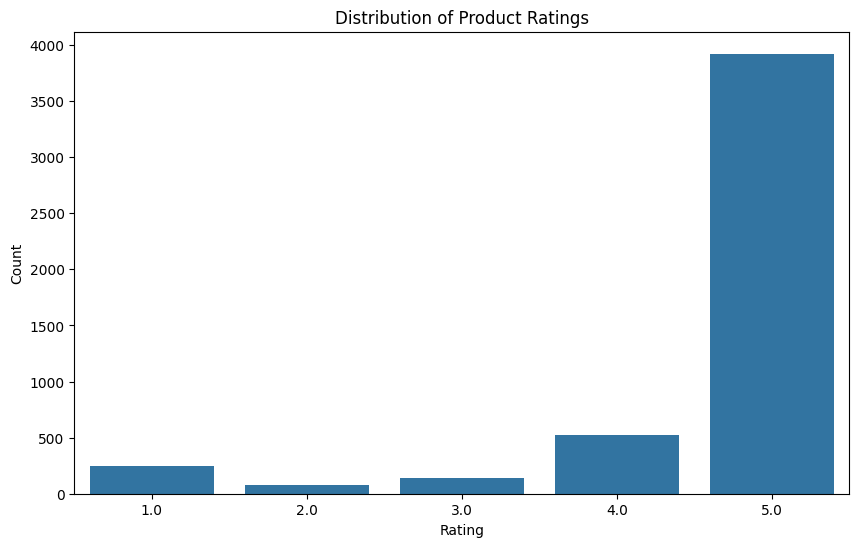

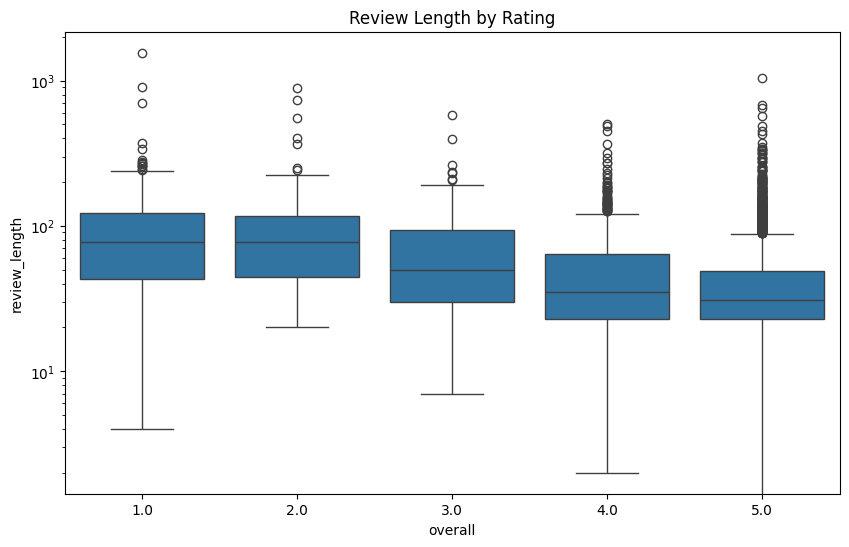

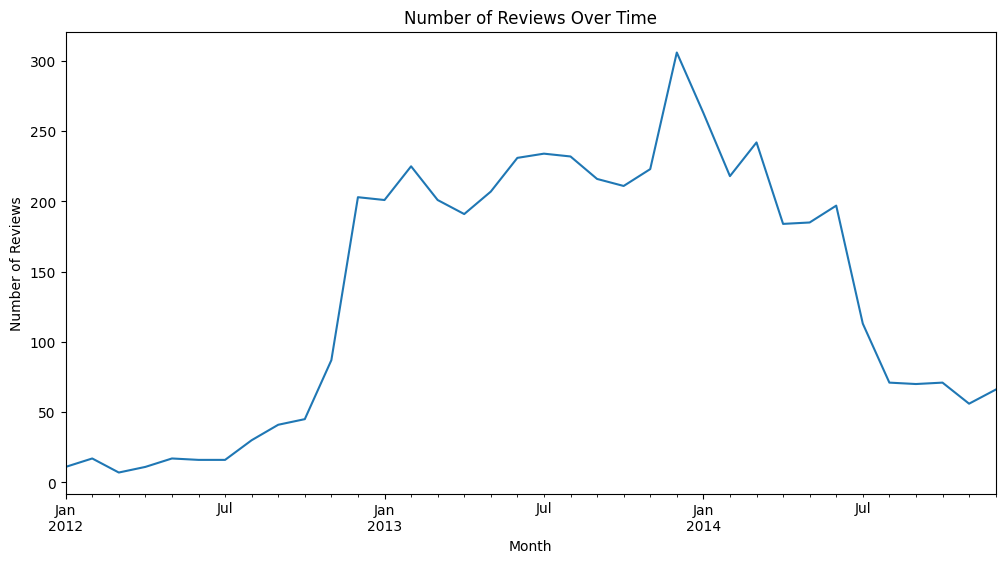

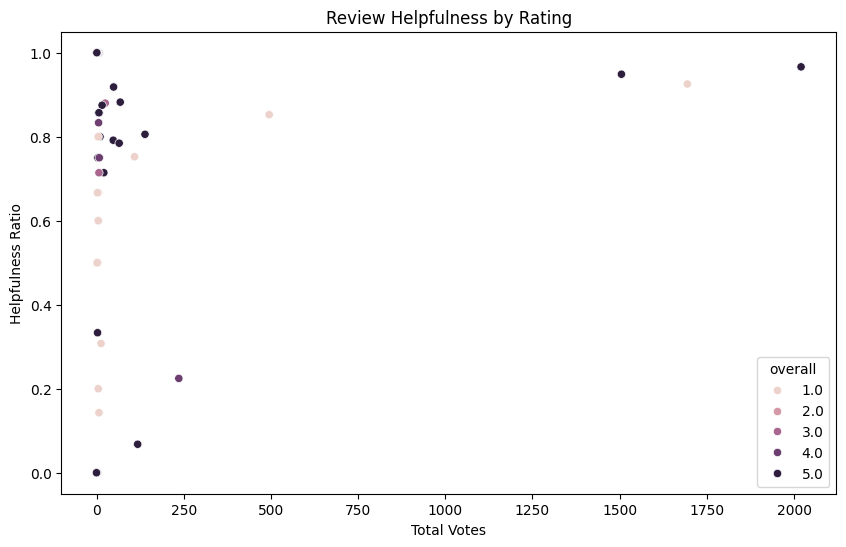

In [7]:
# Step 5: Exploratory Data Analysis (EDA)
# 5.1 Rating Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 5.2 Review Length Analysis
df['review_length'] = df['reviewText'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='review_length', data=df)
plt.title('Review Length by Rating')
plt.yscale('log')  # Using log scale due to outliers
plt.show()

# 5.3 Time Series Analysis
df['year_month'] = df['reviewTime'].dt.to_period('M')
monthly_reviews = df.groupby('year_month').size()
plt.figure(figsize=(12, 6))
monthly_reviews.plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

# 5.4 Helpfulness Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_vote', y='helpfulness_ratio', hue='overall', data=df)
plt.title('Review Helpfulness by Rating')
plt.xlabel('Total Votes')
plt.ylabel('Helpfulness Ratio')
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


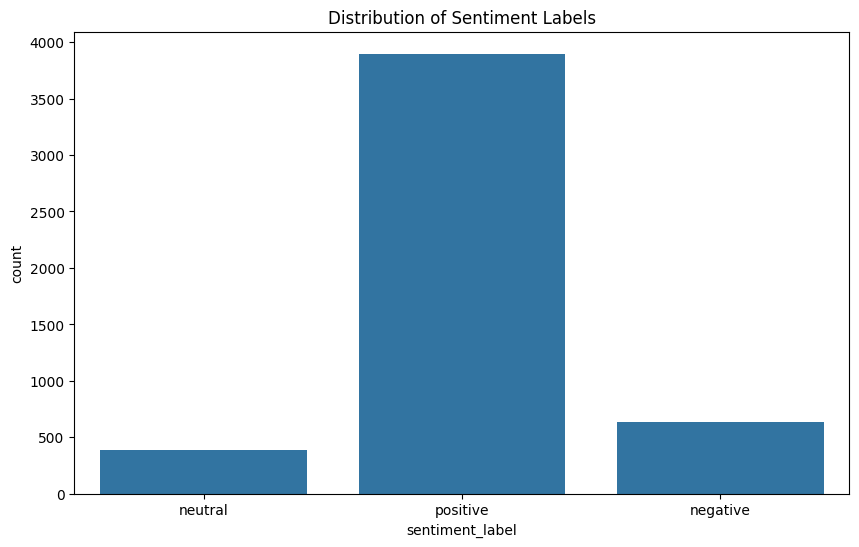

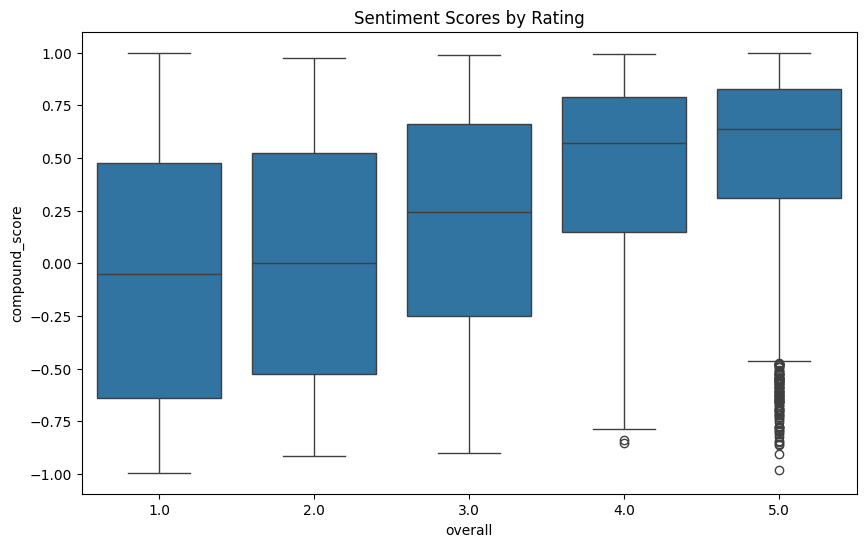

In [9]:
#VADER lexicon downloaded
import nltk
nltk.download('vader_lexicon')
# Step 6: Sentiment Analysis
# Now proceed with sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

# Apply sentiment analysis
df['sentiment'] = df['processed_review'].apply(lambda x: get_sentiment_scores(x))
df['compound_score'] = df['sentiment'].apply(lambda x: x['compound'])
df['sentiment_label'] = df['compound_score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# Sentiment distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

# Sentiment vs Rating visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='compound_score', data=df)
plt.title('Sentiment Scores by Rating')
plt.show()

In [10]:
# Step 7: Topic Modeling (LDA)
# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(df['processed_review'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("Top 10 words per topic:")
display_topics(lda, vectorizer.get_feature_names_out(), 10)

# Assign dominant topic to each review
topic_results = lda.transform(dtm)
df['dominant_topic'] = topic_results.argmax(axis=1)

Top 10 words per topic:
Topic 0:
card phone work memory music great galaxy video bought samsung
Topic 1:
card sandisk phone month problem time ive galaxy bought issue
Topic 2:
price great work card good product sandisk memory storage fast
Topic 3:
card speed class adapter transfer fast use write camera work
Topic 4:
card phone format work device use microsd computer file fat


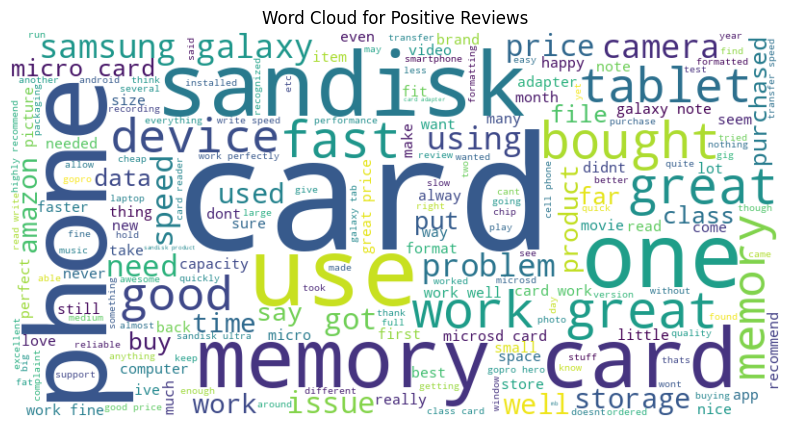

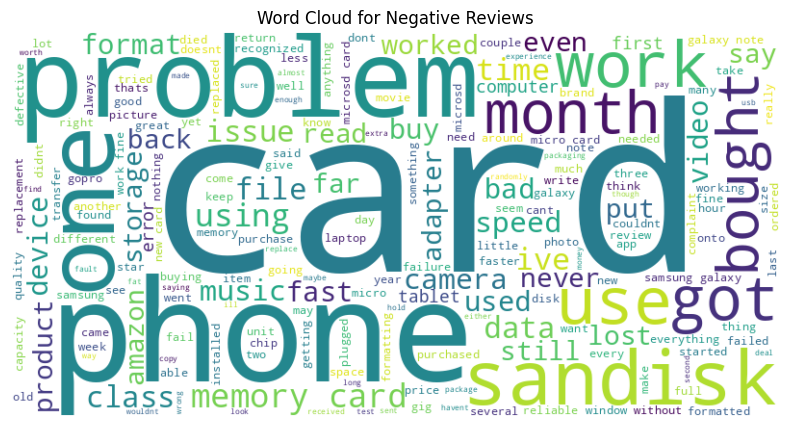

In [11]:
# Step 8: Word Cloud Visualization
# Positive reviews word cloud
positive_reviews = ' '.join(df[df['sentiment_label'] == 'positive']['processed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Negative reviews word cloud
negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['processed_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [14]:
# First, let's ensure all NLTK resources are properly downloaded
import nltk

# Download all required resources in one go
nltk.download('all', quiet=True)

# Now let's verify the specific resources we need
required_resources = [
    'punkt',          # Tokenizer
    'averaged_perceptron_tagger',  # POS tagger
    'maxent_ne_chunker',  # Chunker
    'words',          # Word list
    'stopwords'       # Stopwords
]

for resource in required_resources:
    try:
        nltk.data.find(f'taggers/{resource}')
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from collections import defaultdict
from nltk import pos_tag, word_tokenize
from nltk.chunk import RegexpParser
# Step 9: Key Phrase Extraction and Pain Point Identification
# Function to extract noun phrases with improved error handling
def extract_noun_phrases(text):
    try:
        # Tokenize and POS tag
        tokens = word_tokenize(text)
        tagged = pos_tag(tokens)

        # Define grammar for noun phrases
        grammar = r"""
            NP: {<DT|PP\$>?<JJ>*<NN.*>+}  # Noun phrase with optional determiner, adjectives, and nouns
        """

        # Create chunk parser
        cp = RegexpParser(grammar)

        # Parse the tagged text
        tree = cp.parse(tagged)

        # Extract noun phrases
        noun_phrases = []
        for subtree in tree.subtrees():
            if subtree.label() == 'NP':
                noun_phrases.append(' '.join(word for word, tag in subtree.leaves()))

        return noun_phrases
    except Exception as e:
        print(f"Error processing text: {str(e)[:100]}...")  # Print first 100 chars of error
        return []

# Apply to negative reviews
negative_reviews_df = df[df['sentiment_label'] == 'negative'].copy()
negative_reviews_df['noun_phrases'] = negative_reviews_df['processed_review'].apply(extract_noun_phrases)

# Count frequent noun phrases in negative reviews
noun_phrase_counter = defaultdict(int)
for phrases in negative_reviews_df['noun_phrases']:
    for phrase in phrases:
        if len(phrase.split()) > 1:  # Only consider phrases with multiple words
            noun_phrase_counter[phrase.lower()] += 1

# Get top 20 most common pain points
top_pain_points = sorted(noun_phrase_counter.items(), key=lambda x: x[1], reverse=True)[:20]
print("\nTop 20 Pain Points from Negative Reviews:")
for i, (phrase, count) in enumerate(top_pain_points, 1):
    print(f"{i}. {phrase}: {count} occurrences")


Top 20 Pain Points from Negative Reviews:
1. memory card: 24 occurrences
2. new card: 9 occurrences
3. galaxy note: 8 occurrences
4. samsung galaxy: 8 occurrences
5. another card: 7 occurrences
6. card phone: 5 occurrences
7. long time: 5 occurrences
8. micro card: 5 occurrences
9. card problem: 5 occurrences
10. microsd card: 4 occurrences
11. file card: 4 occurrences
12. card work: 4 occurrences
13. phone phone: 4 occurrences
14. old card: 4 occurrences
15. several time: 4 occurrences
16. android phone: 4 occurrences
17. lifetime warranty: 3 occurrences
18. sandisk memory card: 3 occurrences
19. write speed: 3 occurrences
20. uhs card: 3 occurrences


In [16]:
# Step 10: Product Improvement Recommendations
# Analyze negative reviews by topic
negative_by_topic = df[df['sentiment_label'] == 'negative'].groupby('dominant_topic').size().sort_values(ascending=False)
print("Negative Reviews by Topic:")
print(negative_by_topic)

# Get most common words in negative reviews for each topic
for topic in range(5):
    topic_negative_reviews = df[(df['dominant_topic'] == topic) & (df['sentiment_label'] == 'negative')]['processed_review']
    all_words = ' '.join(topic_negative_reviews).split()
    word_counts = Counter(all_words)
    print(f"\nMost common words in negative reviews for Topic {topic}:")
    print(word_counts.most_common(10))

# Generate recommendations
print("\nProduct Improvement Recommendations:")
print("1. Based on the most frequent pain points, prioritize addressing issues related to:", top_pain_points[0][0])
print("2. The topic with most negative reviews is Topic", negative_by_topic.idxmax(), "- focus improvements in this area")
print("3. Analyze the specific word patterns in negative reviews to identify exact customer concerns")
print("4. For positive aspects, reinforce and highlight:",
      Counter(' '.join(df[df['sentiment_label'] == 'positive']['processed_review']).split()).most_common(5))

Negative Reviews by Topic:
dominant_topic
1    236
0    132
4     95
3     87
2     80
dtype: int64

Most common words in negative reviews for Topic 0:
[('card', 101), ('phone', 73), ('problem', 67), ('one', 38), ('music', 38), ('use', 35), ('galaxy', 34), ('work', 33), ('video', 33), ('memory', 30)]

Most common words in negative reviews for Topic 1:
[('card', 479), ('sandisk', 163), ('phone', 130), ('problem', 128), ('one', 118), ('month', 102), ('bought', 73), ('galaxy', 70), ('got', 66), ('memory', 65)]

Most common words in negative reviews for Topic 2:
[('card', 40), ('work', 34), ('problem', 31), ('price', 25), ('sandisk', 20), ('fast', 20), ('memory', 19), ('product', 13), ('storage', 13), ('one', 13)]

Most common words in negative reviews for Topic 3:
[('card', 120), ('speed', 47), ('class', 32), ('problem', 31), ('write', 31), ('adapter', 23), ('use', 21), ('fast', 21), ('work', 20), ('mb', 20)]

Most common words in negative reviews for Topic 4:
[('card', 212), ('phone', 10

In [17]:
# Step 11: Impact Analysis and Prioritization
# Calculate impact score combining sentiment, helpfulness, and frequency
df['impact_score'] = (df['compound_score'].abs() * df['helpfulness_ratio'] * df['total_vote'].clip(upper=100))

# Get most impactful negative reviews
top_impact_negative = df[(df['sentiment_label'] == 'negative')].sort_values('impact_score', ascending=False).head(10)
print("Top 10 Most Impactful Negative Reviews:")
display(top_impact_negative[['processed_review', 'overall', 'helpfulness_ratio', 'impact_score']])

# Final prioritization
print("\nFinal Prioritization for Product Improvements:")
print("1. Highest priority should be given to issues mentioned in the most impactful negative reviews")
print("2. Next, address the most frequently mentioned pain points across all reviews")
print("3. Consider the cost/benefit ratio of implementing each improvement")
print("4. Validate findings with additional data sources if available")

Top 10 Most Impactful Negative Reviews:


,processed_review,overall,helpfulness_ratio,impact_score
317,card get hot enough painful defective need con...,1.0,0.852525,52.208646
2909,know armed android tablet wearing three wolf t...,4.0,0.224576,8.574322
3807,bought card replace lost gig phone htc seems w...,3.0,0.880000,5.489000
3587,thank god amazon return policy would incensed ...,1.0,0.750000,5.485199
3622,known issue batch card completely die known de...,3.0,0.750000,2.539199
4044,used droid razr maxx kept unmounting became un...,1.0,0.750000,2.294999
1072,say micro work samsung galaxy note simply popp...,5.0,1.000000,2.084000
3632,exactly month half card doneand lost pic video...,2.0,0.666666,1.749999
308,purchased memory card use galaxy smart phone m...,5.0,1.000000,1.560399
4849,died within month stopped able read write went...,1.0,1.000000,1.529999



Final Prioritization for Product Improvements:
1. Highest priority should be given to issues mentioned in the most impactful negative reviews
2. Next, address the most frequently mentioned pain points across all reviews
3. Consider the cost/benefit ratio of implementing each improvement
4. Validate findings with additional data sources if available
